This notebook explains how the new TensorFlow dataset API works and how to build a data pipeline with TensorFlow dataset API which is considered to be better than conventional feed dict

In [1]:
from pathlib import Path
import os
import shutil
import urllib.request
import pandas as pd
from typing import Tuple
import numpy as np
import tensorflow as tf
import csv
from tqdm import tqdm_notebook as tqdm
from IPython.display import Image

In [2]:
np.set_printoptions(precision=5, suppress=True)
tf.logging.set_verbosity(tf.logging.ERROR)

# CSV datasets

First we should write a function to download the csv dataset into a directory mentioned

In [3]:
def download_mnist(base_dir: str, **kwargs) -> Tuple[str]:
    """
    It downloads the MNIST dataset
    in train and test with relative
    to the basedir mentioned.
    
    :param base_dir: The base directory
    :returns: List of directories where train and test data is located
    """
    pwd = Path('.').resolve()
    TRAIN = kwargs.get('train_url')
    TEST = kwargs.get('test_url')
    train_dir = os.path.join(pwd, base_dir, 'train')
    test_dir = os.path.join(pwd, base_dir, 'test')
    if not os.path.exists(os.path.join(pwd, base_dir)):
        os.makedirs(train_dir)
        os.makedirs(test_dir)
        os.chdir(train_dir)
        print(f'Downloading the train.csv in {train_dir}')
        print(f'Downloading the test.csv in {test_dir}')
        with urllib.request.urlopen(TRAIN) as response, open('train.csv', 'wb') as out_file:
            shutil.copyfileobj(response, out_file)
        os.chdir(test_dir)
        with urllib.request.urlopen(TEST) as response, open('test.csv', 'wb') as out_file:
            shutil.copyfileobj(response, out_file)
        os.chdir(pwd)
    return train_dir, test_dir

In [4]:
TRAIN_URL = "https://pjreddie.com/media/files/mnist_train.csv"
TEST_URL  = "https://pjreddie.com/media/files/mnist_test.csv"

In [5]:
tr_dir, ts_dir = download_mnist(
    base_dir='data_mnist', 
    train_url=TRAIN_URL, 
    test_url=TEST_URL)

In [6]:
!tree data_mnist/

data_mnist/
├── test
│   └── test.csv
└── train
    └── train.csv

2 directories, 2 files


Now that we have downloaded the files, we can create the data pipeline and for the csv files. We shall do the following in the data pipeline

- Create the dataset for 10 epochs
- Shuffle the dataset well for each epoch
- Make data preprocessing pipeline in the middle
- Prefetch the dataset in the GPU to avoid GPU starvation
- Create a batch size of 50 datapoints

In [7]:
tr_dir

'/media/antpc/SSD Storage/tf_data/data_mnist/train'

In [8]:
TRAIN_DATA = os.path.join(tr_dir, "train.csv")
TEST_DATA = os.path.join(ts_dir, "test.csv")

In [9]:
def _split_features_labels(x, n_classes):
    x = tf.convert_to_tensor(x)
    y = tf.to_int32(x[0])
    return x[1:], tf.one_hot(indices=tf.cast(y, tf.int32),
                            depth=n_classes)

def get_dataset(file_path: Path, batch: int) -> tf.data.Dataset:
    dataset = tf.data.experimental.CsvDataset(
        filenames=file_path,
        record_defaults=[tf.float32] * 785,
        header=False)
    
    dataset = dataset.map(lambda *x_: _split_features_labels(x_, 10))
    dataset = dataset.shuffle(buffer_size=2000).batch(batch).prefetch(
        tf.data.experimental.AUTOTUNE)
    return dataset.make_one_shot_iterator()

In [10]:
# Define the batch size
BATCH_SIZE = 128

# Create the tf dataset of the mentioned batch size
train_iter = get_dataset(TRAIN_DATA, batch=BATCH_SIZE)

# Initialize the iterator to get the next set of datapoints
next_batch = train_iter.get_next()

# Calculate the total number of datapoints in the dataset
DATA_SHAPE = 0
with open(TRAIN_DATA, 'r') as tr_data:
    reader = csv.reader(tr_data)
    for _ in reader:
        DATA_SHAPE += 1

# Now calculate how many times we can create a batch form this dataset
b_chunks = DATA_SHAPE // BATCH_SIZE + 1 # Offset 1 for right indexing


In [11]:
# Now create a tensorflow session to digest the data
with tf.Session() as sess:
    # Using tf range instead of python range for better speed
    for i in range(1, b_chunks): 
        # It shall automatically absorb all the batch chunks
        X_batch, y_batch = sess.run(next_batch)
        
        # Make sure that the X_batch and y_batch is of desired size
        assert X_batch.shape == (BATCH_SIZE, 784)
        assert y_batch.shape == (BATCH_SIZE, 10) # Because one-hot encoded
        print(f'Processing on chunk {i}')

Processing on chunk 1
Processing on chunk 2
Processing on chunk 3
Processing on chunk 4
Processing on chunk 5
Processing on chunk 6
Processing on chunk 7
Processing on chunk 8
Processing on chunk 9
Processing on chunk 10
Processing on chunk 11
Processing on chunk 12
Processing on chunk 13
Processing on chunk 14
Processing on chunk 15
Processing on chunk 16
Processing on chunk 17
Processing on chunk 18
Processing on chunk 19
Processing on chunk 20
Processing on chunk 21
Processing on chunk 22
Processing on chunk 23
Processing on chunk 24
Processing on chunk 25
Processing on chunk 26
Processing on chunk 27
Processing on chunk 28
Processing on chunk 29
Processing on chunk 30
Processing on chunk 31
Processing on chunk 32
Processing on chunk 33
Processing on chunk 34
Processing on chunk 35
Processing on chunk 36
Processing on chunk 37
Processing on chunk 38
Processing on chunk 39
Processing on chunk 40
Processing on chunk 41
Processing on chunk 42
Processing on chunk 43
Processing on chunk 

Processing on chunk 347
Processing on chunk 348
Processing on chunk 349
Processing on chunk 350
Processing on chunk 351
Processing on chunk 352
Processing on chunk 353
Processing on chunk 354
Processing on chunk 355
Processing on chunk 356
Processing on chunk 357
Processing on chunk 358
Processing on chunk 359
Processing on chunk 360
Processing on chunk 361
Processing on chunk 362
Processing on chunk 363
Processing on chunk 364
Processing on chunk 365
Processing on chunk 366
Processing on chunk 367
Processing on chunk 368
Processing on chunk 369
Processing on chunk 370
Processing on chunk 371
Processing on chunk 372
Processing on chunk 373
Processing on chunk 374
Processing on chunk 375
Processing on chunk 376
Processing on chunk 377
Processing on chunk 378
Processing on chunk 379
Processing on chunk 380
Processing on chunk 381
Processing on chunk 382
Processing on chunk 383
Processing on chunk 384
Processing on chunk 385
Processing on chunk 386
Processing on chunk 387
Processing on ch

In [15]:
assert i == b_chunks - 1

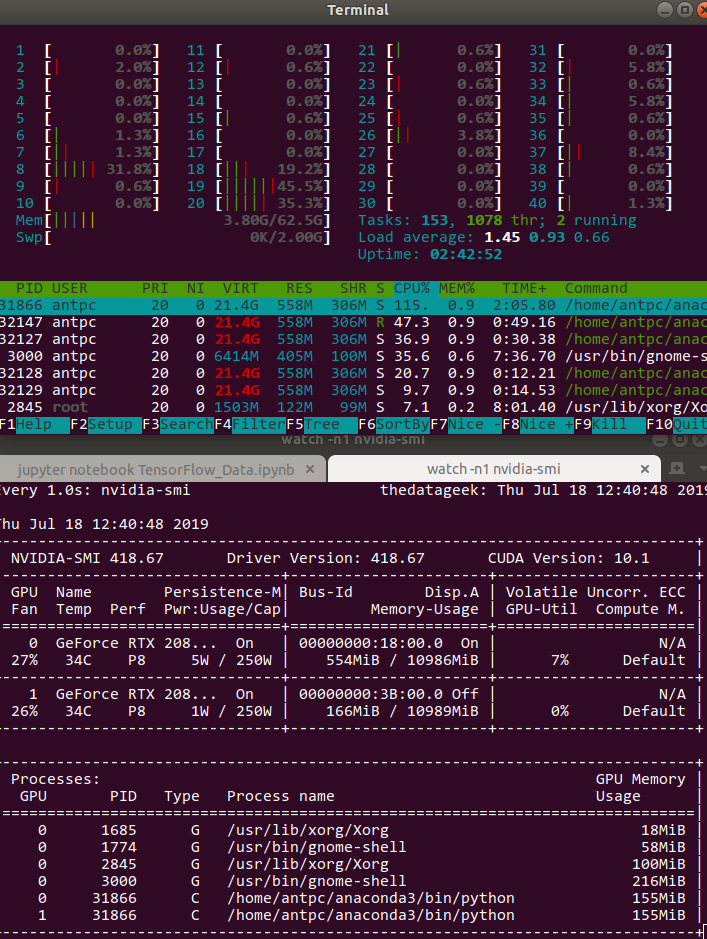

In [19]:
Image('/home/antpc/Pictures/load.png')

from 

In [ ]:
DATA_DIR = Path('.')

# TFRecords

# Image URLs

# Text Corpus

In [57]:
!mkdir -p data_mnist/{train, test}